第一章提到，最常见的监督式学习任务包括回归任务(预测值)和分类任务(预测类)。
<br>第二章探讨了一个回归任务--预测住房价格，用到了线性回归、决策树以及随机森林等各种算法(我们会在后续章节中进一步讲解这些算法)。
<br>本章中我们会把注意力转向分类系统。

# MNIST

数据介绍：本章使用MNIST数据集，这是一组由美国高中生和人口调查局员工手写的70000个数字的图片。每张图像都用其代表的数字标记。这个数据集被广为使用，因此也被称作是机器学习领域的“Hello World”:但凡有人想到了一个新的分类算法，都会想看看在MNIST上的执行结果。因此只要是学习机器学习的人，早晚都要面对MNIST。

In [1]:
# 使用sklearn的函数来获取MNIST数据集
from sklearn.datasets import fetch_openml
import numpy as np
import os
# to make this notebook's output stable across runs
np.random.seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 为了显示中文
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# 耗时巨大
def sort_by_target(mnist):
    reorder_train=np.array(sorted([(target,i) for i, target in enumerate(mnist.target[:60000])]))[:,1]
    reorder_test=np.array(sorted([(target,i) for i, target in enumerate(mnist.target[60000:])]))[:,1]
    mnist.data[:60000]=mnist.data[reorder_train]
    mnist.target[:60000]=mnist.target[reorder_train]
    mnist.data[60000:]=mnist.data[reorder_test+60000]
    mnist.target[60000:]=mnist.target[reorder_test+60000]

In [3]:
mnist=fetch_openml('mnist_784',version=1,cache=True)
mnist.target=mnist.target.astype(np.int8)
sort_by_target(mnist)

In [4]:
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [5]:
mnist.data.shape

(70000, 784)

In [6]:
X,y=mnist["data"],mnist["target"]
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

In [8]:
28*28

784

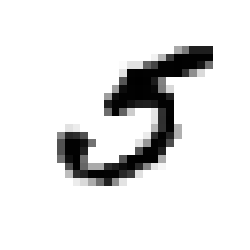

In [9]:
# 展示图片
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
some_digit = X[36000]
plot_digit(X[36000].reshape(28,28))

In [10]:
y[36000]

5

In [11]:
# 更好看的图片展示
def plot_digits(instances,images_per_row=10,**options):
    size=28
    # 每一行有一个
    image_pre_row=min(len(instances),images_per_row)
    images=[instances.reshape(size,size) for instances in instances]
#     有几行
    n_rows=(len(instances)-1) // image_pre_row+1
    row_images=[]
    n_empty=n_rows*image_pre_row-len(instances)
    images.append(np.zeros((size,size*n_empty)))
    for row in range(n_rows):
        # 每一次添加一行
        rimages=images[row*image_pre_row:(row+1)*image_pre_row]
        # 对添加的每一行的额图片左右连接
        row_images.append(np.concatenate(rimages,axis=1))
    # 对添加的每一列图片 上下连接
    image=np.concatenate(row_images,axis=0)
    plt.imshow(image,cmap=mpl.cm.binary,**options)
    plt.axis("off")

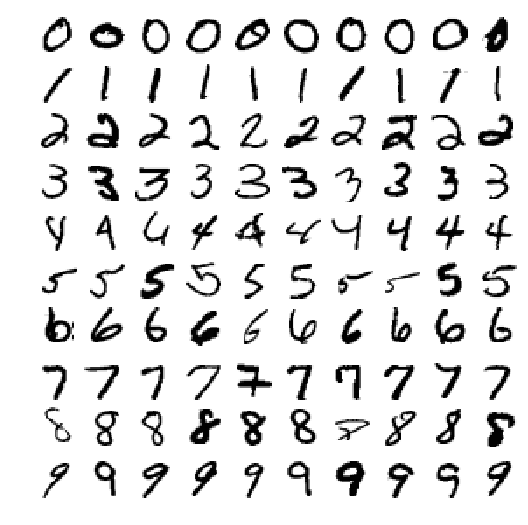

In [12]:
plt.figure(figsize=(9,9))
example_images=np.r_[X[:12000:600],X[13000:30600:600],X[30600:60000:590]]
plot_digits(example_images,images_per_row=10)
plt.show()

接下来，我们需要创建一个测试集，并把其放在一边。

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

同样，我们还需要对训练集进行洗牌，这样可以保证交叉验证的时候，所有的折叠都差不多。此外，有些机器学习算法对训练示例的循序敏感，如果连续输入许多相似的实例，可能导致执行的性能不佳。给数据洗牌，正是为了确保这种情况不会发生。

In [14]:
import numpy as np

shuffer_index=np.random.permutation(60000)
X_train,y_train=X_train[shuffer_index],y_train[shuffer_index]

# 训练一个二分类器

现在，我们先简化问题，只尝试识别一个数字，比如数字5，那么这个"数字5检测器",就是一个二分类器的例子，它只能区分两个类别：5和非5。先为此分类任务创建目录标量

In [22]:
y_train_5=(y_train==5)
y_test_5=(y_test==5)

接着挑选一个分类器并开始训练。一个好的选择是随机梯度下降(SGD)分类器，使用sklearn的SGDClassifier类即可。这个分类器的优势是：能够有效处理非常大型的数据集。这部分是因为SGD独立处理训练实例，一次一个(这也使得SGD非常适合在线学习任务)。

In [23]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(max_iter=5,tol=-np.infty,random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [24]:
sgd_clf.predict([some_digit])

array([ True])

# 性能考核

评估分类器比评估回归器要困难很多，因此本章将会用很多篇幅来讨论这个主题，同时也会涉及许多性能考核的方法。

## 使用交叉验证测量精度

随机交叉验证和分层交叉验证效果对比

In [27]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96225, 0.9645 , 0.94765])

In [26]:
# 类似于分层采样，每一折的分布类似
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96225
0.9645
0.94765


我们可以看到两种交叉验证的准确率都达到了95%上下，看起来很神奇，不过在开始激动之前，让我们来看一个蠢笨的分类器，将所有图片都预测为‘非5’

In [29]:
from sklearn.base import BaseEstimator
# 随机预测模型
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

我们可以看到，准确率也超过了90%！这是因为我们只有大约10%的图像是数字5，所以只要猜一张图片不是5,那么有90%的时间都是正确的，简直超过了大预言家。
<br>这说明，准确率通常无法成为分类器的首要性能指标，特别是当我们处理偏斜数据集的时候(也就是某些类别比其他类更加频繁的时候)

## 混淆矩阵

评估分类器性能的更好的方法是混淆矩阵。总体思路就是统计A类别实例被分成B类别的次数。例如，要想知道分类器将数字3和数字5混淆多少次，只需要通过混淆矩阵的第5行第3列来查看。
<br>要计算混淆矩阵，需要一组预测才能将其与实际目标进行比较。当然可以通过测试集来进行预测，但是现在我们不动它(测试集最好保留到项目的最后,准备启动分类器时再使用)。最为代替，可以使用cross_val_predict()函数:

`cross_val_predict` 和 `cross_val_score` 不同的是，前者返回预测值，并且是每一次训练的时候，用模型没有见过的数据来预测

In [30]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [31]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53417,  1162],
       [ 1350,  4071]], dtype=int64)

上面的结果表明：第一行所有'非5'(负类)的图片中,有53417被正确分类(真负类)，1162，错误分类成了5(假负类)；第二行表示所有'5'（正类）的图片中，有1350错误分类成了非5(假正类)，有4071被正确分类成5(真正类).
<br>一个完美的分类器只有真正类和真负类，所以其混淆矩阵只会在其对角线(左上到右下)上有非零值

In [34]:
y_train_perfect_predictions = y_train_5

In [35]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

混淆矩阵能提供大量信息，但有时我们可能会希望指标简洁一些。正类预测的准确率是一个有意思的指标,它也称为分类器的精度(如下)。
$$Precision(精度)=\frac{TP}{TP+FP}$$
其中TP是真正类的数量，FP是假正类的数量。
做一个简单的正类预测，并保证它是正确的，就可以得到完美的精度(精度=1/1=100%)

这并没有什么意义，因为分类器会忽略这个正实例之外的所有内容。因此，精度通常会与另一个指标一起使用，这就是召回率，又称为灵敏度或者真正类率(TPR)：它是分类器正确检测到正类实例的比率(如下):
$$Recall(召回率)=\frac{TP}{TP+FN}$$
FN是假负类的数量

## 精度和召回率

In [36]:
# 使用sklearn的工具度量精度和召回率
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7779476399770686

In [37]:
recall_score(y_train_5, y_train_pred)

0.7509684560044272

我们可以看到，这个5-检测器，并不是那么好用，大多时候，它说一张图片为5时，只有77%的概率是准确的，并且也只有75%的5被检测出来了

下面，我们可以将精度和召回率组合成单一的指标，称为F1分数。
$$F_1=\frac{2}{\frac{1}{Precision}+\frac{1}{Recall}}=2*\frac{Pre*Rec}{Pre+Rec}=\frac{TP}{TP+\frac{FN+FP}{2}}$$
要计算F1分数，只需要调用f1_score()即可

In [38]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7642200112633752

F1分数对那些具有相近的精度和召回率的分类器更为有利。这不一定一直符合预期，因为在某些情况下，我们更关心精度，而另一些情况下，我们可能真正关系的是召回率。
<br>例如：假设训练一个分类器来检测儿童可以放心观看的视频，那么我们可能更青睐那种拦截了好多好视频(低召回率),但是保留下来的视频都是安全(高精度)的分类器，而不是召回率虽高，但是在产品中可能会出现一些非常糟糕的视频分类器(这种情况下，你甚至可能会添加一个人工流水线来检查分类器选出来的视频)。
<br>反过来说，如果你训练一个分类器通过图像监控来检测小偷:你大概可以接受精度只有30%，只要召回率能达到99%。(当然，安保人员会接收到一些错误的警报，但是几乎所有的窃贼都在劫难逃)
<br>遗憾的是，鱼和熊掌不可兼得：我们不能同时增加精度并减少召回率，反之亦然，这称为精度/召回率权衡

## 精度/召回率权衡

在分类中，对于每个实例，都会计算出一个分值，同时也有一个阈值，大于为正例，小于为负例。通过调节这个阈值，可以调整精度和召回率。

In [39]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([150526.40944343])

In [41]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [42]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [43]:
# 返回决策分数，而不是预测结果
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
y_scores.shape

(60000,)

In [44]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

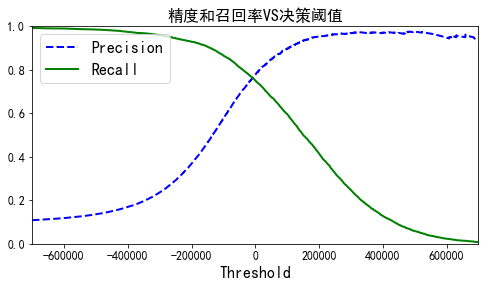

In [46]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.title("精度和召回率VS决策阈值", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

可以看见，随着阈值提高，召回率下降了，也就是说，有真例被判负了，精度上升，也就是说，有部分原本被误判的负例，被丢出去了。

你可以会好奇，为什么精度曲线会比召回率曲线要崎岖一些，原因在于，随着阈值提高，精度也有可能会下降 4/5 => 3/4(虽然总体上升)。另一方面，阈值上升，召回率只会下降。

现在就可以轻松通过选择阈值来实现最佳的精度/召回率权衡了。还有一种找到最好的精度/召回率权衡的方法是直接绘制精度和召回率的函数图。

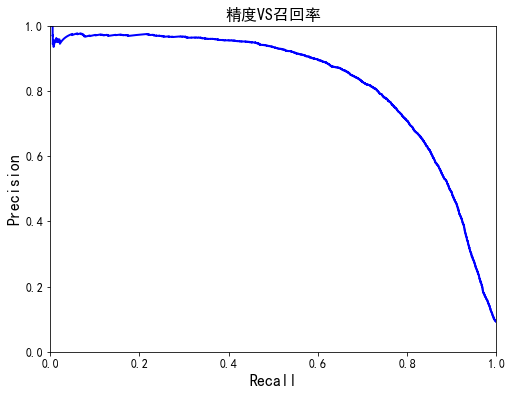

In [48]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.title("精度VS召回率", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

可以看见，从80%的召回率往右，精度开始急剧下降。我们可能会尽量在这个陡降之前选择一个精度/召回率权衡--比如召回率60%以上。当然，如何选择取决于你的项目。

假设我们决定瞄准90%的精度目标。通过绘制的第一张图(放大一点)，得出需要使用的阈值大概是70000.要进行预测(现在是在训练集上),除了调用分类器的predict方法，也可以使用这段代码：

In [59]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)

0.8712083540527101

In [60]:
recall_score(y_train_5, y_train_pred_90)

0.6463752075262866

现在我们就有了一个精度接近90%的分类器了，如果有人说，“我们需要99%的精度。”，那么我就要问：“召回率是多少？”

## ROC曲线

还有一种经常与二元分类器一起使用的工具，叫做受试者工作特征曲线(简称ROC)。它与精度/召回率曲线非常相似，但绘制的不是精度和召回率，而是真正类率(召回率的另一种称呼)和假正类率(FPR)。FPR是被错误分为正类的负类实例比率。它等于1-真负类率(TNR)，后者正是被正确分类为负类的负类实例比率，也称为奇异度。因此ROC曲线绘制的是灵敏度和(1-奇异度)的关系

| ~  | 1 |0|
| -- | --- |--|
| 1  | TP  |FN|
| 0  | FP  |TN|

$$FPR=\frac{FP}{FP+TN}$$
$$Recall=\frac{TP}{TP+FN}$$

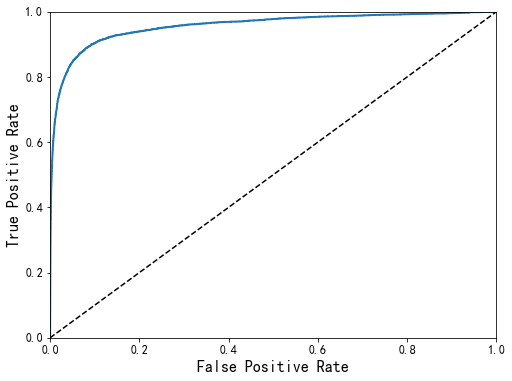

In [61]:
# 使用 roc_curve()函数计算多种阈值的TPR和FPR
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

这里同样面对一个折中权衡:召回率(TPR)很高,分类器产生的假正类(FPR)就越多。虚线表示纯随机的ROC曲线；一个优秀的分类器(向左上角)。
<br>有一种比较分类器的方式是测量曲线下面积(AUC)。完美的ROC AUC等于1，纯随机分类的ROC AUC等于0.5

In [62]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9562435587387078

ROC曲线和精度/召回率(或PR)曲线非常相似，因此，你可能会问，如何决定使用哪种曲线。
<br>一个经验法则是，当正类非常少见或者你更关注假正类而不是假负类时，应该选择PR曲线，反之选择ROC曲线。
<br>例如，看前面的ROC曲线图时，以及ROC AUC分数时，你可能会觉得分类器真不错。但这主要是应为跟负类(非5)相比，正类(数字5)的数量真的很少。相比之下，PR曲线清楚地说明分类器还有改进的空间(曲线还可以更接近右上角)

### 训练一个随机森林分类器，并计算ROC和ROC AUC分数

In [64]:
# 具体RF的原理，第七章介绍
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

c:\users\sha\anaconda3\envs\tensorflow-gpu\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


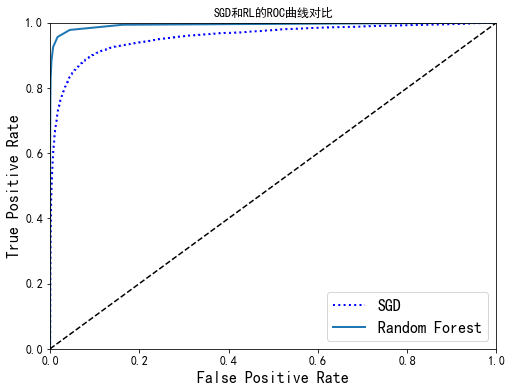

In [66]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.title("SGD和RL的ROC曲线对比")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [67]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

测量精度和召回率

In [68]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [69]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

# 多类别分类器

二元分类器在两个类别中区分，而多类别分类器(也称为多项分类器),可以区分两个以上的类别。
<br>随机森林算法和朴素贝叶斯分类器可以直接处理多个类别。也有一些严格的二元分类器，比如支持向量分类器或线性分类器。但有多种策略，可以让我们用几个二元二类器实现多类别分类的目的
<br>例如：我们可以训练0-9的10个二元分类器组合，那个分类器给的高，就分为哪一类，这称为一对多(OvA)策略
<br>另一种方法，是为每一对数字训练一个二元分类器:一个用来区分0-1，一个区分0-2，一个区分1-2，依次类推。这称为一对一(OvO)策略，解决N分类，需要(N)*(N-1)/2分类器，比如MNIST问题，需要45个分类器。OvO的主要优点在于每个分类器只需要用到部分训练集对其必须区分的两个类别进行训练。
<br>有些算法(例如支持向量机算法)，在数据规模增大时，表现糟糕，因此对于这类算法，OvO是一个优秀的选择，由于在较小的训练集上分别训练多个分类器比在大型数据集上训练少数分类器要快得多。但对于大多数二元分类器，OvA策略还是更好的选择。

In [70]:
# 使用0-9进行训练，在sgd内部，sklearn使用了10个二元分类器，
#获得它们对图片的决策分数，然后选择最高的类别
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

我们可以看到 sgd对输入的结果输出了10个预测分数，而不是1个

In [71]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-152619.46799791, -441052.22074349, -249930.3138537 ,
        -237258.35168498, -447251.81933158,  120565.05820991,
        -834139.15404835, -188142.48490477, -555223.79499145,
        -536978.92518594]])

In [72]:
np.argmax(some_digit_scores)

5

训练分类器的时候，目标类别的列表会存储在classes_这个属性中，按值的大小进行排序

In [73]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

强制使用OVO策略

In [75]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [76]:
len(ovo_clf.estimators_)

45

随机森林的多分类，不需要OvA或者OVO策略

In [77]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [78]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

对分类器进行评估

In [79]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84993001, 0.81769088, 0.84707706])

评测结果大概都为80%以上，如果是随机分类器，准确率大概是10%左右，所以这个结果不是太糟糕，但是依然有提升的空间，比如使用标准化，进行简单的缩放

In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91211758, 0.9099955 , 0.90643597])

## 错误分析

如果这是一个真正的项目，我们将遵循第二章机器学习项目清单的步骤:探索数据准备的选项，尝试多个模型，列出最佳模型并使用GridSearchCV对超参数进行微调，尽可能自动化，等等。在这里，假设我们已经找到一个有潜力的模型，现在希望找到一些方法，对其进一步改进。方法之一就是分析其类型错误。

首先，看一下混淆矩阵

In [81]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5749,    4,   22,   11,   11,   40,   36,   11,   36,    3],
       [   2, 6490,   43,   24,    6,   41,    8,   12,  107,    9],
       [  53,   42, 5330,   99,   87,   24,   89,   58,  159,   17],
       [  46,   41,  126, 5361,    1,  241,   34,   59,  129,   93],
       [  20,   30,   35,   10, 5369,    8,   48,   38,   76,  208],
       [  73,   45,   30,  194,   64, 4614,  106,   30,  170,   95],
       [  41,   30,   46,    2,   44,   91, 5611,    9,   43,    1],
       [  26,   18,   73,   30,   52,   11,    4, 5823,   14,  214],
       [  63,  159,   69,  168,   15,  172,   54,   26, 4997,  128],
       [  39,   39,   27,   90,  177,   40,    2,  230,   78, 5227]],
      dtype=int64)

In [82]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

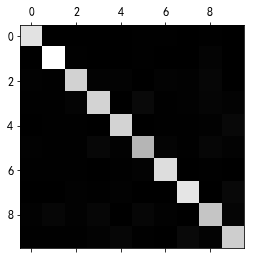

In [83]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

5稍微暗一点，可能意味着数据集中5的图片少，也可能是分类器在5上的执行效果不行。实际上，这二者都属实。
<br>让我们把焦点都放在错误上。首先，我们需要将混淆矩阵中的每个值都除以相应类别中的图片数，这样比较的而是错误率，而不是错误的绝对值(后者对图片数量较多的类别不公平)

In [84]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

行表示实际类别，列表示预测的类别，可以看到 8 9 列比较亮，容易其他数字容易被分错为8 9， 8 9 行业比较亮，说明 8 9 容易被错误分为其他数字。此外3 容易被错分为 5，5也容易被错分为4

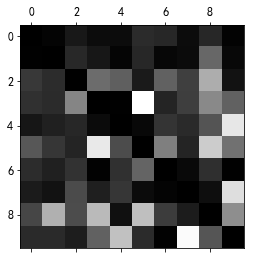

In [87]:
np.fill_diagonal(norm_conf_mx, 0) # 填充主对称轴
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

分析混淆矩阵，通常可以帮助我们深入了解如何改进分类器。通过上面的图，我们可以花费更多时间来改进8 9的分类，以及修正 3 5 的混淆上。
<br>例如，可以试着收集更多这些数字的训练集，
<br>或者开发新特征来改进分类器--举个例子，写一个算法来计算闭环的数量，比如(8有两个，6有一个，5没有)。
<br>再或者，对图片进行预处理，让某些模式更加突出，比如闭环之类的。

分析单个错误也可以为分类器提供洞察：它在做什么？为什么失败？但这通常更加困难和耗时。例如，我们来看看数字3和数字5的例子：

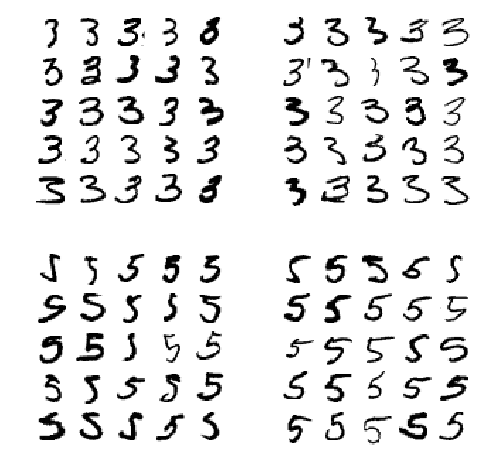

In [88]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

我们可以看到，虽然有一些数字容易混淆，但大多数，还是比较好分类的，但算法还是会分错。因为SGD模型是一个线性模型，它所做的就是为每一个像素分配一个各个类别的权重，当它看到新的图像时，将加权后的像素强度汇总，从而得到一个分数进行分类。而数字3和5只在一部分像素位上有区别，所以分类器很容易将其搞混.

数字3和5之间的主要区别在于连接顶线和下方弧线中间的小线条的位置。如果我们写的数字3将连续点略往左移，分类器就可能将其分类为5，反之亦然。换言之，这个分类器对图像位移和旋转非常敏感，因此，减少3 5混淆的方法之一是对数字进行预处理，确保他们位于中心位置，并且没有旋转。这也有助于减少其他错误。

# 多标签分类

到目前位置，每个实例都只有一个输出，但某些情况下，我们需要分类器为每个实例产出多个类别，比如，为照片中的每个人脸附上一个标签。
<br>假设分类器经过训练，已经可以识别三张脸 A B C，那么当看到A和C的合照时，应该输出[1,0,1]，这种输出多个二元标签的分类系统成为多标签分类系统
<br>下面以k近邻算法为例(不是所有的分类器都支持多标签)

In [89]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [90]:
knn_clf.predict([some_digit])

array([[False,  True]])

结果正确，5显然小于7，同时是奇数

评估多标签分类器的方法很多，如何选择正确的度量指标取决于我们的项目。比如方法之一是测量每个标签的F1分数(或者是之前讨论过的任何其他二元分类器指标),然后简单的平均。

In [92]:
# 耗时巨大
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.97709078477525

这里假设了所有的标签都是同等重要，但实际的数据可能并不均衡，可以修改`average="weighted"`,来给每个标签设置一个等于其自身支持的权重

# 多输出分类

现在，我们将讨论最后一种分类任务--多输出多分类任务(简称为多输出分类)。简单而言，它是多标签分类的泛化，其标签也可以是多种类别的(比如有两个以上的值)
<br>说明:构建一个去除图片中噪声的系统。给它输入一个带噪声的图片，它将(希望)输出一张干净的数字图片，跟其他MNIST图片一样，以像素强度的一个数组作为呈现方式。
<br>需要注意的是：这个分类器的输出时多个标签(一个像素点一个标签),每一个标签有多个值(0-255)。所以这是一个多输出分类器系统的例子。

分类和回归之间的界限有时候很模糊，比如这个系统，可以说，预测像素强度更像是回归任务，而不是分类。而多输出系统也不仅仅限于分类任务，可以让一个系统给每个实例输出多个标签，同时包括类别标签和值标签

首先还是从创建训练集和测试集开始，使用Numpy的randint 来给Mnist图片的像素强度增加噪声。目标是将图片还原为原始图片。

In [93]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

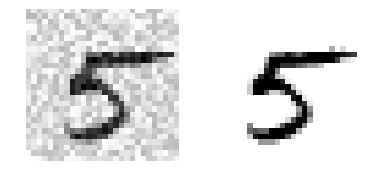

In [94]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

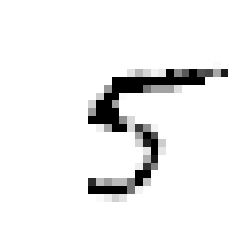

In [95]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

拓展一：
<br> DummyClassifier(随机预测分类器)

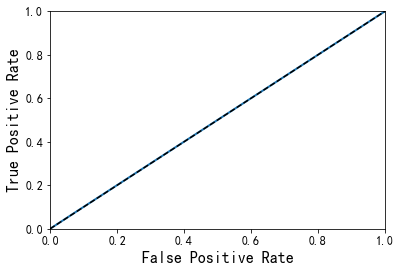

In [96]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

拓展二：<br>
K近邻分类器

In [97]:
# 耗时较大
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)
y_knn_pred = knn_clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

拓展三：
<br>平移图片

c:\users\sha\anaconda3\envs\tensorflow-gpu\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


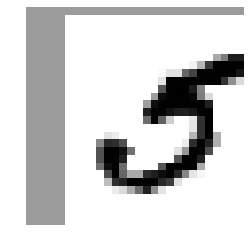

In [98]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

拓展四：
<br>通过平移图片，增强数据集，再训练

In [99]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [100]:
# 耗时巨大，大概几十分钟
knn_clf.fit(X_train_expanded, y_train_expanded)
y_knn_expanded_pred = knn_clf.predict(X_test)

In [101]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [102]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.       , 0.       , 0.5053645, 0.       , 0.       , 0.       ,
        0.       , 0.4946355, 0.       , 0.       ]])

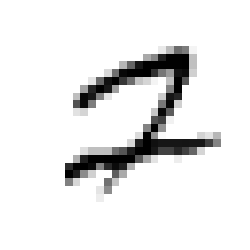

In [103]:
plot_digit(ambiguous_digit)

# 练习

## 1. 为mnist数据集构建一个测试集精度达到97%的分类器(提示：KNeighborsClassifier，调节 weights 和 n_neighbors)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed: 57.2min remaining: 38.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 72.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [18]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [19]:
grid_search.best_score_

0.97325

In [20]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## 2.将MNIST往任意方向(上下左右)移动一个像素的功能，再用这个拓展过的训练集来训练模型

In [15]:
from scipy.ndimage.interpolation import shift
from sklearn.neighbors import KNeighborsClassifier

In [16]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

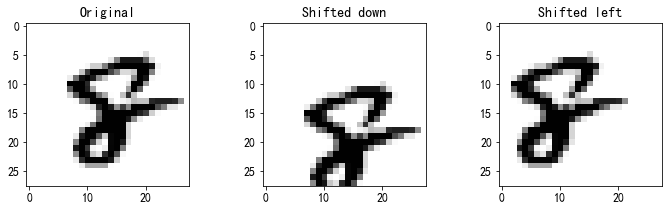

In [17]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [18]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [19]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [20]:
knn_clf = KNeighborsClassifier(n_neighbors=4,weights='distance',n_jobs=-1)

In [21]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [24]:
y_pred = knn_clf.predict(X_test)

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9763

## 3. 处理泰坦尼克数据集

本问题目标是预测乘客是否存活问题，数据集可以从kaggle获取[Titanic challenge](https://www.kaggle.com/c/titanic) 

In [26]:
# 首先是加载数据集
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [27]:
# 看一下数据结构
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

In [28]:
# 看一下数据缺失的情况
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [29]:
# 看一下数字属性
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [30]:
# 存活率
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [31]:
# 1，2，3等仓的人数
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [32]:
# 性别比例
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [33]:
# 从哪上船 C=Cherbourg, Q=Queenstown, S=Southampton
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
U      2
Name: Embarked, dtype: int64

In [34]:
# 获取有缺失的属性里面出现最频繁的值，用以做填充
from sklearn.base import BaseEstimator, TransformerMixin
    
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [36]:
# 数据预处理
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs=["Age", "SibSp", "Parch", "Fare"]
cat_attribs=["Pclass", "Sex", "Embarked"]

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
    ])

cat_pipeline = Pipeline([
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])
X_train = full_pipeline.fit_transform(train_data)

In [38]:
X_train

array([[22.,  1.,  0., ...,  0.,  1.,  0.],
       [38.,  1.,  0., ...,  0.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  1.,  0.],
       ...,
       [28.,  1.,  2., ...,  0.,  1.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  0.],
       [32.,  0.,  0., ...,  1.,  0.,  0.]])

In [37]:
y_train = train_data["Survived"]

In [39]:
# 使用线性SVM来处理
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [40]:
X_test = full_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [41]:
# 评估结果
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7320304165247986

In [42]:
# 使用随机森林来处理
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8060137895812053

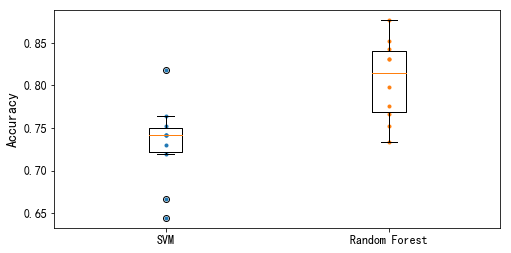

In [43]:
# 画出两个图评估结果的盒型图
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

1.     最大值（或减掉outlier之后的最大值）

2.     位于75%百分位的值

3.     中间值

4.     位于25%百分位的值

5.     最小值

In [44]:
# 给年龄分组
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [45]:
# 将兄弟姐妹配偶和孩子父母数求和
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## 4.创建一个垃圾邮件分类器 

### 首先获取数据

In [49]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()
# fetch_spam_data()
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]
len(ham_filenames),len(spam_filenames)

(2500, 500)

In [80]:
ham_filenames[0]

'00001.7c53336b37003a9286aba55d2945844c'

我们使用python的 `email` 工具包来读取和处理邮件数据

In [50]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [51]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

查看一下垃圾邮件和正常邮件内容

In [52]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [53]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


有些邮件会带有多个部分，比如图片和附件，这里取出来看看

In [54]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [55]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [56]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [57]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

可以看到正常邮件的附件要比垃圾邮件的所带有的`text/plain`更少，同时，一些垃圾邮件带有`pgp`这个签名

取出邮件头看一看

In [58]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [59]:
#  看一下主题
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [60]:
# 切分训练集和测试集
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# 将 text/html 文件翻译为文本文件 去掉 <head>,<a> &gt; &nbsp;
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [62]:
# 将 text/html 去出来看一下
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [86]:
len(html_spam_emails)

150

In [63]:
# 看一下去除html标签的
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [64]:
# 将邮件转换为文本
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [90]:
for part in sample_html_spam.walk():
    print(part.get_content_type())

text/html


In [65]:
# 查看效果
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


In [66]:
# 自然语言工具包
import nltk
# 文本转化
stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [69]:
# 对url进行提取
import urlextract # may require an Internet connection to download root domain names

url_extractor = urlextract.URLExtract()
print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


In [70]:
# 将前面的处理方式进行集成整合
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [71]:
# 统计词频
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

文本词频转向量，取出前n个最频繁出现的

In [72]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [73]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int32'>'
	with 20 stored elements in Compressed Sparse Row format>

In [74]:
# 单词向量
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]], dtype=int32)

In [75]:
# 词频向量对应的词
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

In [76]:
#  构建处理管道
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

a) liblinear：使用了开源的liblinear库实现，内部使用了坐标轴下降法来迭代优化损失函数。

b) lbfgs：拟牛顿法的一种，利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数。

c) newton-cg：也是牛顿法家族的一种，利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数。

d) sag：即随机平均梯度下降，是梯度下降法的变种，和普通梯度下降法的区别是每次迭代仅仅用一部分的样本来计算梯度，适合于样本数据多的时候。

In [77]:
# 使用logist回归
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................... , score=0.981, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.985, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.991, total=   0.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


0.9858333333333333

In [78]:
# 验证效果
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 95.88%
Recall: 97.89%
